# Figure3

In [106]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats
import re,sys,os
from collections import defaultdict, Counter
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba

In [107]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [108]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [109]:
store="../results/"

In [110]:
cluster_order=["SMK","UVL","APB","MRD","POL","HRD","GNS","AGE"]
cluster_order2=["SMK","UVL","APB","MRD","POL","HRD","GNS","AGE","UND"]
cluster_colors=["red","blue","green","purple","brown","hotpink","c","y"]
cluster_colors2=["red","blue","green","purple","brown","hotpink","c","y","grey"]

In [111]:
# import data
df0=pd.read_csv("../data/ICI_response_cohort_938.tsv",sep="\t",index_col=0)

# TMB cut-off from FM-ONE

In [112]:
pb_para=pd.read_csv("../analysis_in_R/Passing_Bablok_results.tsv"
                    ,sep="\t",index_col=0)
pb_para

,EST,SE,LCI,UCI
Intercept,1.814174,NaN,0.973855,2.791982
Slope,0.047230,NaN,0.040266,0.052601


In [113]:
cutoff1=( 10-pb_para.loc["Intercept","EST"]) /pb_para.loc["Slope","EST"]
cutoff1

173.3166492146599

In [114]:
# check CI
cutoff1_l=( 10-pb_para.loc["Intercept","LCI"]) /pb_para.loc["Slope","LCI"]
cutoff1_u=( 10-pb_para.loc["Intercept","UCI"]) /pb_para.loc["Slope","UCI"]
print(cutoff1_l,cutoff1_u)

224.1649670514298 137.03253770579335


In [115]:
blca2018=pd.read_csv("../analysis_in_R/Nature2018_BLCA_FM1_WES.tsv",sep="\t",index_col=0)

r= 0.820, P= 2.91e-54


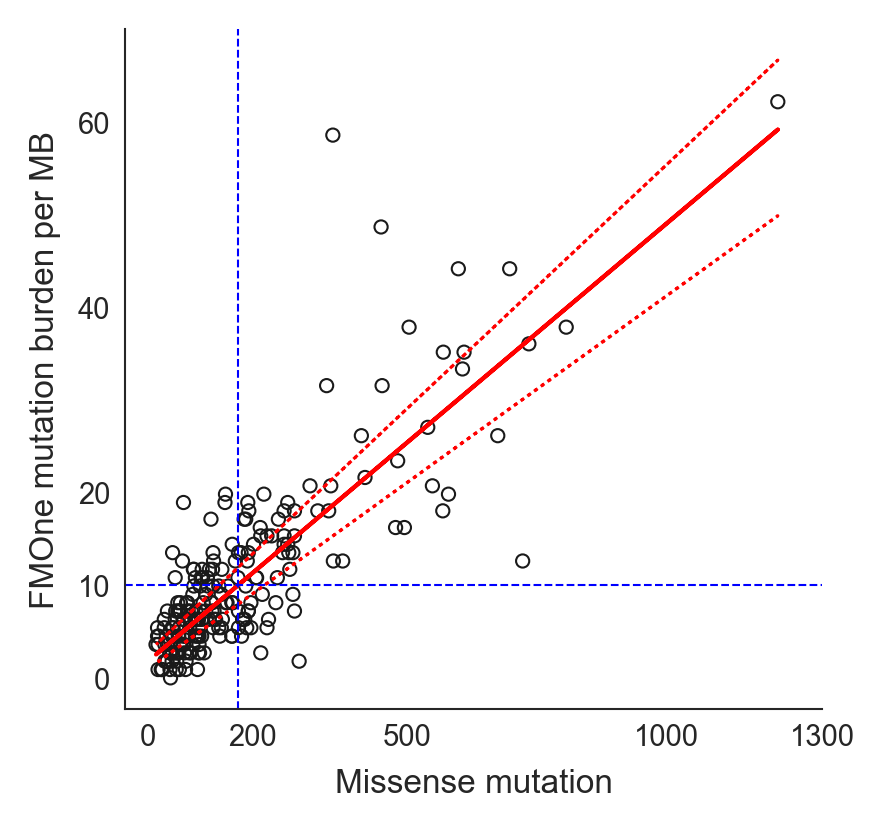

In [116]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
tmp_df=blca2018.copy()
val1,val2="Missense_Mutation","FMOne mutation burden per MB"
tmp_df=tmp_df.dropna(subset=[val1,val2])
x=tmp_df[val1]
y=tmp_df[val2]
ax.scatter(x,y,s=10,fc="None",ec="k",lw=0.5)

r,p=stats.pearsonr(x,y)
print("r= {:.3f}, P= {:.2e}".format(r,p))

y2=pb_para.loc["Intercept","EST"]+pb_para.loc["Slope","EST"]*x

ax.plot(x,y2,c="red",lw=1)

y3=pb_para.loc["Intercept","LCI"]+pb_para.loc["Slope","LCI"]*x
y4=pb_para.loc["Intercept","UCI"]+pb_para.loc["Slope","UCI"]*x

ax.plot(x,y3,c="red",ls="dotted",lw=0.75)
ax.plot(x,y4,c="red",ls="dotted",lw=0.75)

ax.axhline(y=10, color="blue",ls="dashed")

ax.axvline(x=cutoff1,color="blue",ls="dashed")

ax.set_xlabel("Missense mutation")
ax.set_ylabel(val2)
ax.set_xticks([0,200,500,1000,1300])
ax.set_yticks([0,10,20,40,60])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [117]:
blca2018["FM_high"]=(blca2018["FMOne mutation burden per MB"]>=10).astype(int)
blca2018["MM_high"]=(blca2018["Missense_Mutation"]>=cutoff1).astype(int)
ct=pd.crosstab(blca2018["FM_high"],blca2018["MM_high"])
ct                                                                  

MM_high,0,1
FM_high,,
0,118,19
1,22,59


In [118]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(blca2018["FM_high"],blca2018["MM_high"])

0.5942068464541905

# TMB cut-off by ROC

In [119]:
# ROC curve, AUC, explore optimal threshold
from sklearn.metrics import roc_curve,roc_auc_score,auc
flag="Responder"
value="Missense_Mutation"
plt_df=df.copy()

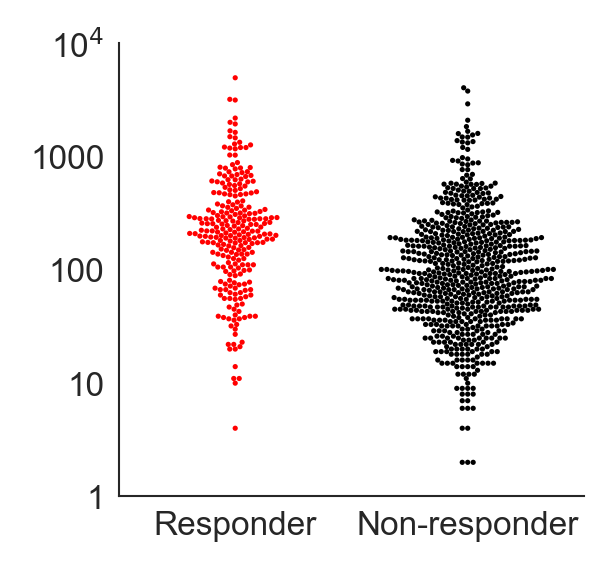

In [120]:
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
sns_df=plt_df.copy()
cat=flag
val="Missense_Mutation_log10"
ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=1.25,order=[1,0],palette=["red","black"])
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend([])
ax.set_title("",fontsize=10)
ax.tick_params(axis="both",labelsize=6)

ax.set_xticklabels(["Responder","Non-responder"], rotation=0, fontsize=8)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

Youden index: TPR=0.65,　FPR=0.30,　Threshold=165.00


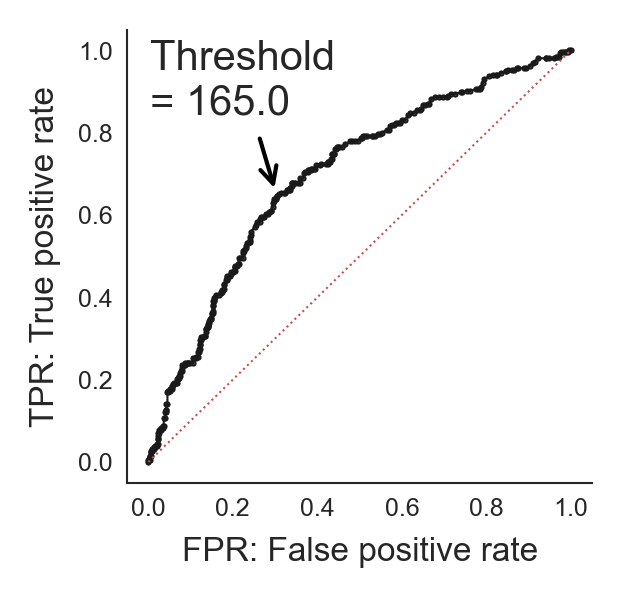

In [121]:
# plot ROC curve
plt_df=plt_df.loc[:,[flag,value]].dropna()
y_true=plt_df[flag]
y_score=plt_df[value]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc=roc_auc_score(y_true, y_score)

fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
ax.plot(fpr, tpr, marker='o',ms=0.5,c="k")
ax.set_xlabel('FPR: False positive rate',fontsize=8)
ax.set_ylabel('TPR: True positive rate',fontsize=8)
ax.plot(np.linspace(0,1), np.linspace(0,1), c="r",ls="dotted")
ax.tick_params(labelsize=6)

# Youden index
yd_idx = np.argmax( abs(tpr -fpr) )
yd_threshold = thresholds[yd_idx]
print("Youden index: TPR={:.2f},　FPR={:.2f},　Threshold={:.2f}".format(tpr[yd_idx],fpr[yd_idx],yd_threshold))

# plot with Threshold
arrow_dict = dict(color = "black",arrowstyle = "->")
ax.annotate("Threshold\n= {}".format(thresholds[yd_idx]),xy=(fpr[yd_idx],tpr[yd_idx]),
             size=10,xytext=(fpr[yd_idx]-0.3,tpr[yd_idx]+0.2), arrowprops = arrow_dict )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [122]:
df0["TMB_high"]=(df0["Missense_Mutation"]>cutoff1).astype(float)
df0["TMB_high2"]=(df0["Missense_Mutation"]>yd_threshold).astype(float)

# Compare response rate

## irGS vs non irGS

In [123]:
df=df0.copy()

In [33]:
input_df=df.copy()
flag="Responder"
cat1="irGS"
value="Missense_Mutation_log10"
ct=pd.crosstab(input_df[flag],input_df[cat1])
ct=ct.loc[:,[1,0]]
ct

irGS,1,0
Responder,,
0.0,404,280
1.0,216,38


In [34]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 7.16e-15
Chi-square p= 8.15e-14


In [35]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

216/620
38/318


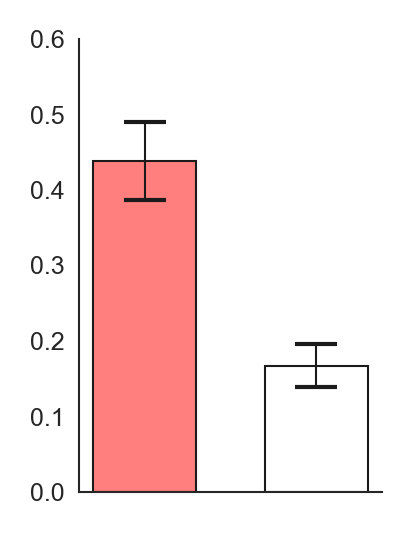

In [44]:
n=len(ratios)
left=range(n)
colors=["red","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.set_ylim(0,0.6)
ax.legend([])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## TMB high vs low

In [45]:
input_df=df.copy()
cat2="TMB_high"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high,1,0
Responder,,
0.0,201,483
1.0,157,97


In [46]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 2.62e-19
Chi-square p= 1.05e-19


In [47]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

157/358
97/580


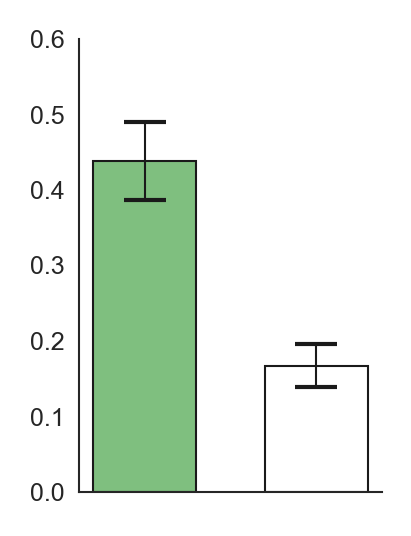

In [48]:
n=len(ratios)
left=range(n)
colors=["green","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

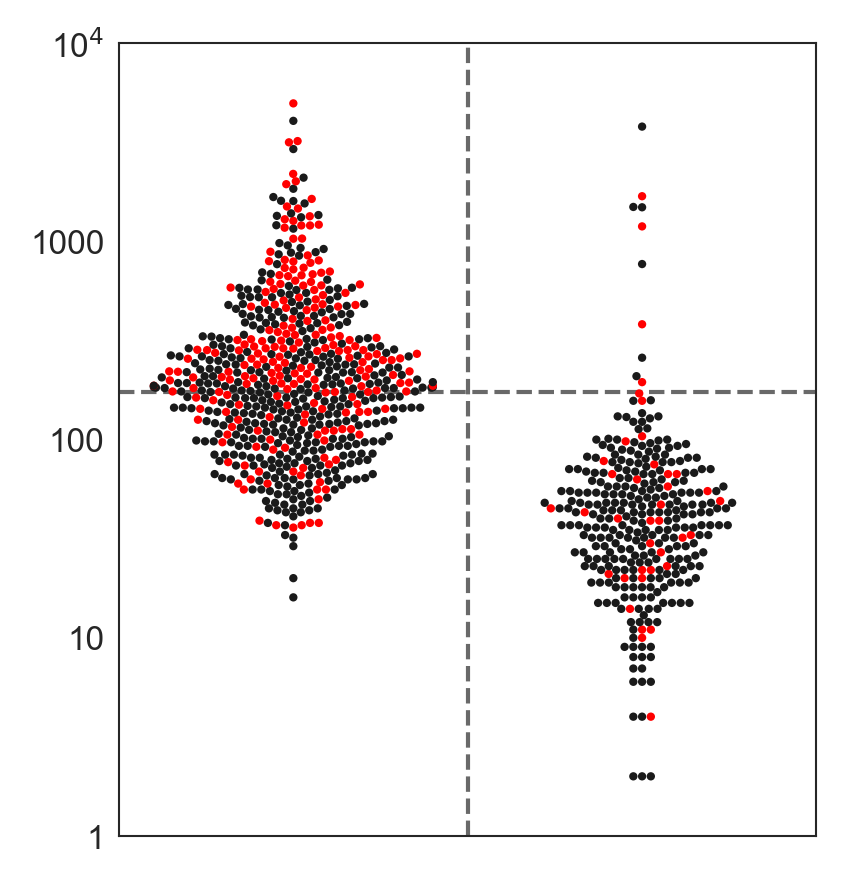

In [50]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axhline(y=np.log10(cutoff1),c="dimgrey",lw=1,ls="dashed")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels([])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])
#plt.savefig("Response_divided_GS_TMB_all.png",transparent=True)

In [51]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [53]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.reindex(['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS','TMB low\nnon-irGS'],axis=1)
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,195,6,209,274
1.0,153,4,63,34


In [54]:
# compare between TMB-low groups
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,209,274
1.0,63,34


Chi-square p= 9.46e-05


In [55]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

153/348
4/10
63/272
34/308


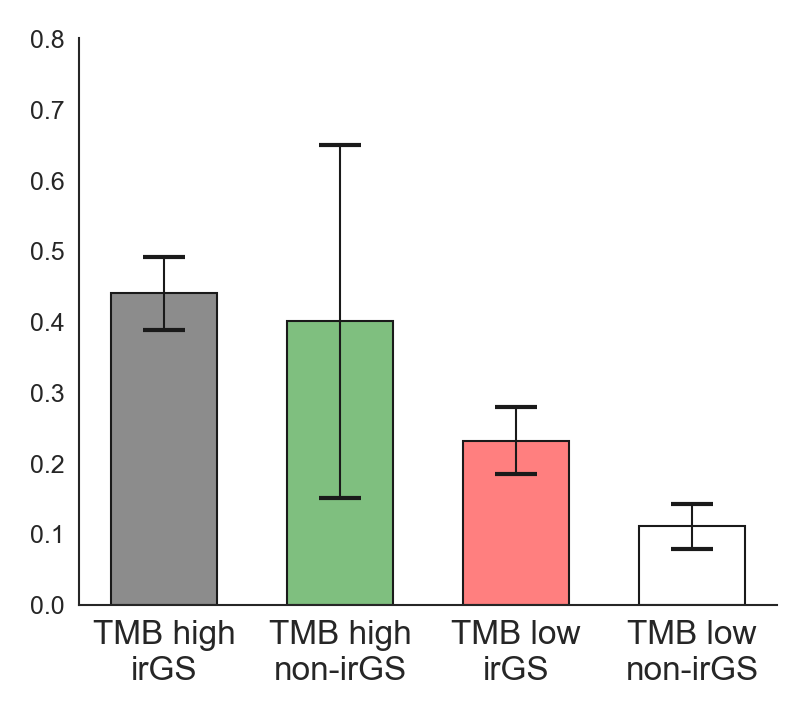

In [58]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","green","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression 

In [73]:
Counter(df["irGS"])

Counter({1: 620, 0: 318})

In [72]:
Counter(df["TMB_high"])

Counter({1.0: 358, 0.0: 580})

In [64]:
Counter(df["CancerType"])

Counter({'Melanoma': 335,
         'Lung': 127,
         'Bladder': 263,
         'HNSCC': 118,
         'Others': 95})

In [61]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "3_Lung",
         'Bladder': "4_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "5_Others"})

In [62]:
Counter(df["Sex"])

Counter({'Female': 326, 'Male': 612})

In [63]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

In [74]:
m_age=np.nanmedian( df["Age"].astype(float))
print(m_age)
age_high=[]
for idx in df.index:
    if df.loc[idx,"Age"] >= m_age:
        age_high.append(1)
    elif df.loc[idx,"Age"] < m_age:
        age_high.append(0)
    else:
        age_high.append(np.nan)
    
df["Age_high"]=age_high
Counter(age_high)

61.5


Counter({0: 319, 1: 319, nan: 300})

In [68]:
Y="Responder"
categories=["irGS","TMB_high","CancerTypeR","Sex_male","Age_high"]

In [71]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,3.940,(2.70 - 5.74),0.000
TMB_high,3.889,(2.88 - 5.26),0.000
CancerTypeR[T.2_Head_neck],0.482,(0.29 - 0.81),0.006
CancerTypeR[T.3_Lung],1.002,(0.65 - 1.55),0.993
CancerTypeR[T.4_Bladder],0.762,(0.53 - 1.09),0.136
CancerTypeR[T.5_Others],0.333,(0.18 - 0.62),0.001
Sex_male,1.192,(0.88 - 1.62),0.262
Age_high,1.067,(0.75 - 1.52),0.719


1.01e-12
1.16e-18
5.60e-03
9.93e-01
1.36e-01
6.08e-04
2.62e-01
7.19e-01


In [76]:
# multivariate
categories=["irGS","TMB_high","CancerTypeR"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.135,(0.09 - 0.21),0.000
CancerTypeR[T.2_Head_neck],0.838,(0.48 - 1.46),0.531
CancerTypeR[T.3_Lung],1.333,(0.83 - 2.13),0.229
CancerTypeR[T.4_Bladder],0.879,(0.60 - 1.29),0.506
CancerTypeR[T.5_Others],0.889,(0.44 - 1.78),0.739
irGS,2.223,(1.41 - 3.50),0.001
TMB_high,2.684,(1.88 - 3.83),0.000


1.55e-19
5.31e-01
2.29e-01
5.06e-01
7.39e-01
5.44e-04
5.59e-08


# Response per subtype

In [129]:
df=df0.copy()

In [131]:
ct=pd.crosstab(df["Responder"],df["Tumor genomic subtype"])
ct=ct.loc[:,cluster_order2]
ct

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
Responder,,,,,,,,,
0.0,58,155,182,0,0,91,22,141,35
1.0,38,94,75,6,1,14,3,16,7


38/96
94/249
75/257
6/6
1/1
14/105
3/25
16/157
7/42


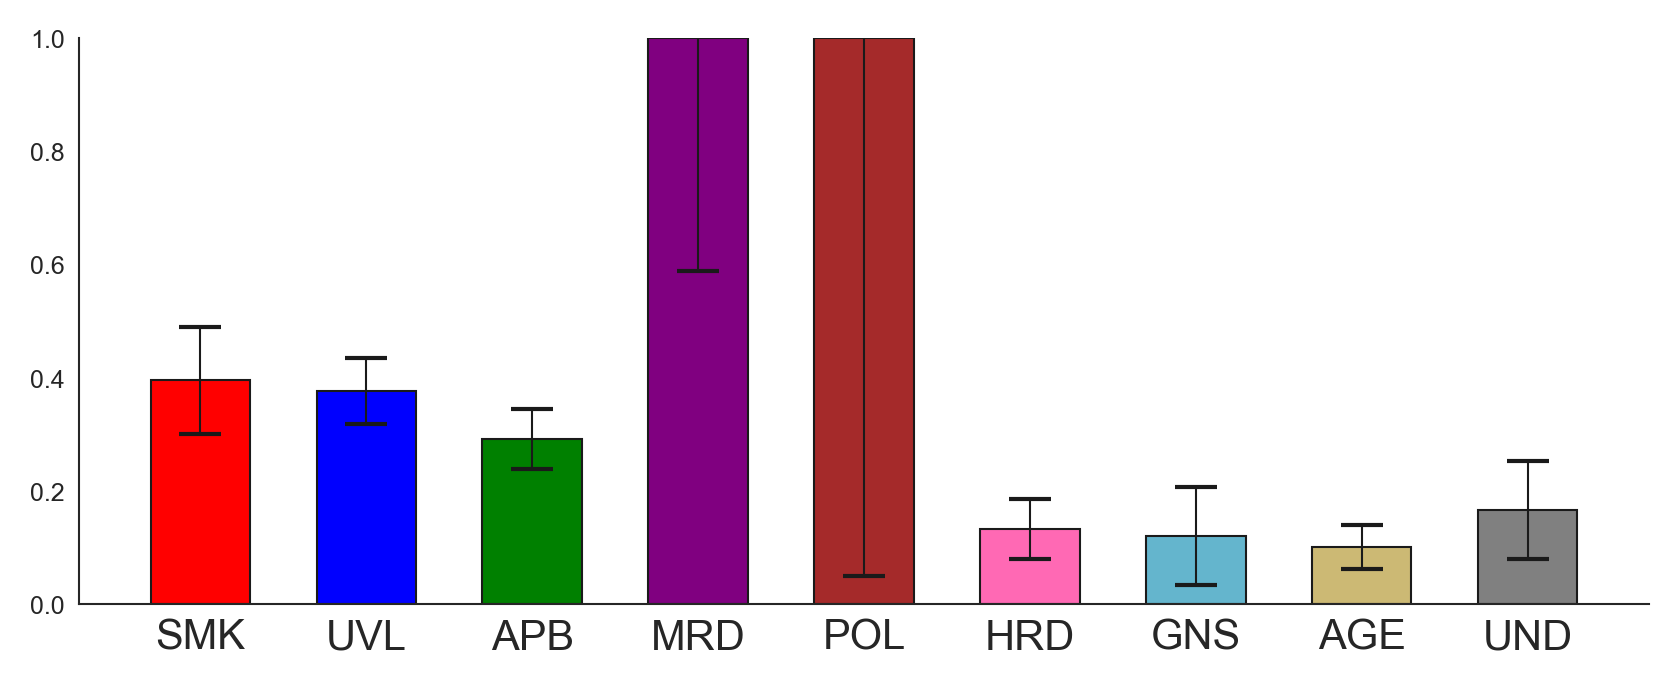

In [126]:
# bar plot with binomial confidence interval
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=cluster_colors2

fig=plt.figure(figsize=(n*0.75,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels(labels, rotation=0, fontsize=10)
ax.legend([])
ax.set_ylim(0,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [127]:
ct=pd.crosstab(df["CancerType"],df["Tumor genomic subtype"])
ct.loc[["Melanoma","HNSCC","Lung","Bladder","Others"],cluster_order2]

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
CancerType,,,,,,,,,
Melanoma,2,247,0,0,0,33,12,24,17
HNSCC,14,2,38,0,0,15,0,43,6
Lung,71,0,15,0,0,13,5,19,4
Bladder,8,0,191,4,0,17,0,31,12
Others,1,0,13,2,1,27,8,40,3


# Per Drug type

In [132]:
df=df0.copy()

In [133]:
cat1="irGS"
cat2="TMB_high"

class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [134]:
Counter(df["Treatment"])

Counter({'CTLA4': 117,
         'PD1': 464,
         'CTLA4->PD1': 18,
         'CTLA4+PD1': 48,
         'PDL1': 220,
         'PD1/PDL1': 61,
         'CTLA4+PD1/PDL1': 10})

In [135]:
df1=df[df["Treatment"]=="PD1"]
df2=df[df["Treatment"]=="PDL1"]
df3=df[df["Treatment"].isin(["CTLA4",'CTLA4->PD1',"CTLA4+PDL1","CTLA4+PD1","CTLA4+PD1/PDL1"])]
dfs=[df1,df2,df3]

PD1 n= 464


class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,81,163
1.0,30,22


chisquare p= 0.000924
Fisher p= 0.00144

PDL1 n= 220


class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,78,42
1.0,15,3


chisquare p= 0.122
Fisher p= 0.178

CTLA4 n= 193


class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,30,56
1.0,12,6


chisquare p= 0.0125
Fisher p= 0.0173



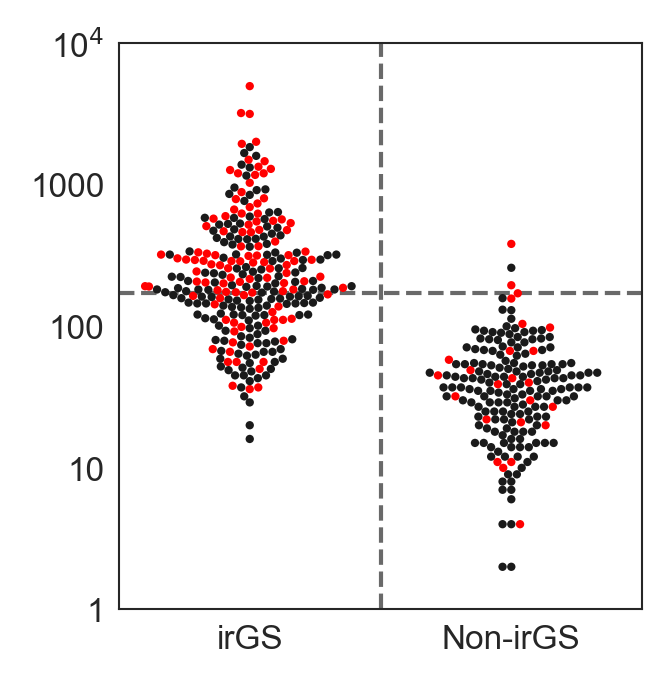

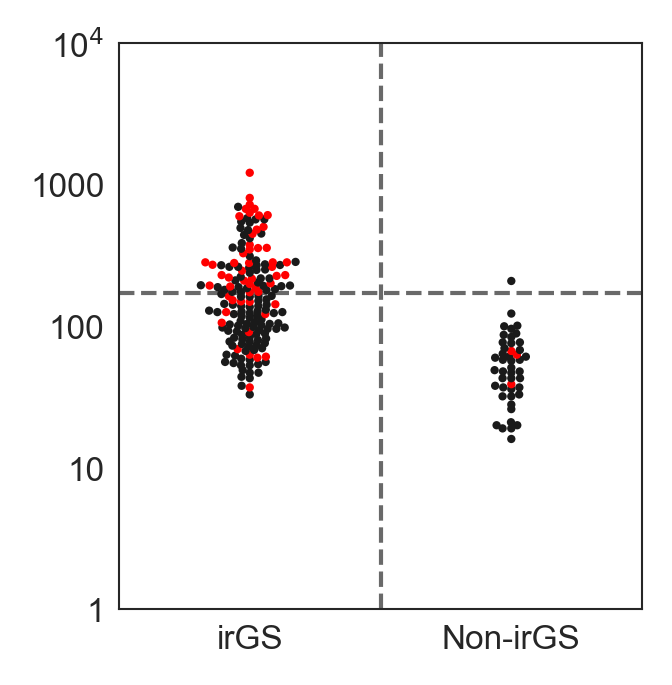

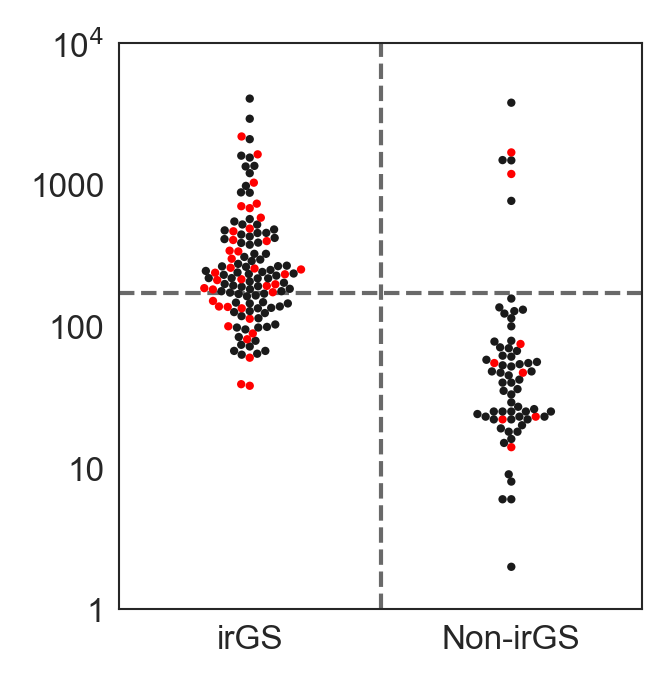

In [137]:
flag="Responder"
cat1="irGS"
cat2="TMB_high"
value="Missense_Mutation_log10"
for plt_df in dfs:
    fig=plt.figure(figsize=(2.25,2.5))
    ax=fig.add_subplot(111)
    sns.swarmplot(x=cat1,y=value,data=plt_df,
                  s=2,ax=ax,hue=flag,hue_order=[0,1],
                  palette=["k","red"],
                 order=[1,0])
    ax.set_ylabel("",fontsize=8)
    ax.set_xlabel("")
    ax.axhline(y=np.log10(173),c="dimgrey",lw=1,ls="dashed")
    ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
    ax.tick_params(labelsize=6)
    ax.set_xticklabels(["irGS","Non-irGS"], rotation=0, fontsize=8)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
    ax.legend([])#bbox_to_anchor=(1, 1),fontsize=8,title="Objective response")
    #plt.savefig("Response_divided_GS_TMB_all.png",transparent=True)
    ct4=pd.crosstab(plt_df["class4"],plt_df[flag]).T
    ct=ct4.reindex(["TMB low\nirGS","TMB low\nnon-irGS"],axis=1)
    res=stats.chi2_contingency(ct,correction=False)
    res2=stats.fisher_exact(ct)
    print(plt_df["Treatment"].unique()[0],"n=", plt_df.shape[0])
    display(ct)
    print("chisquare p= %.3g"%res[1])
    print("Fisher p= %.3g"%res2[1],end="\n\n")

80/165
2/3
30/111
22/185

37/81
0/1
15/93
3/45

25/83
2/6
12/42
6/62



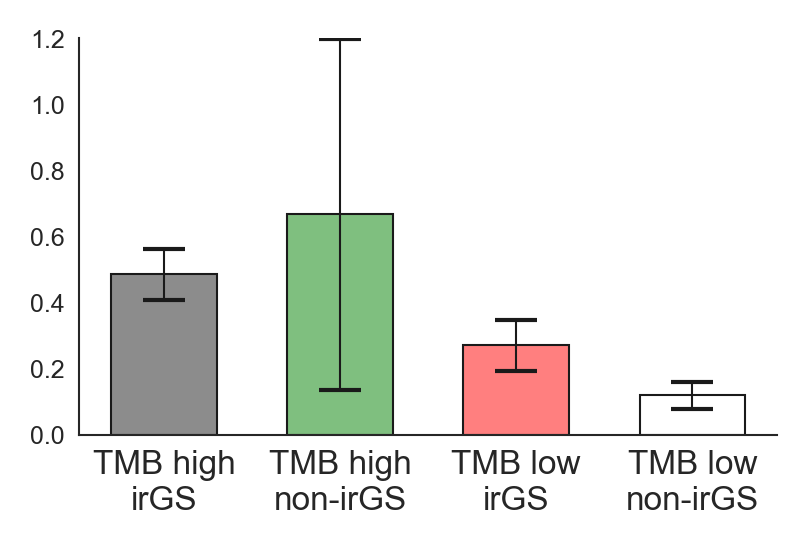

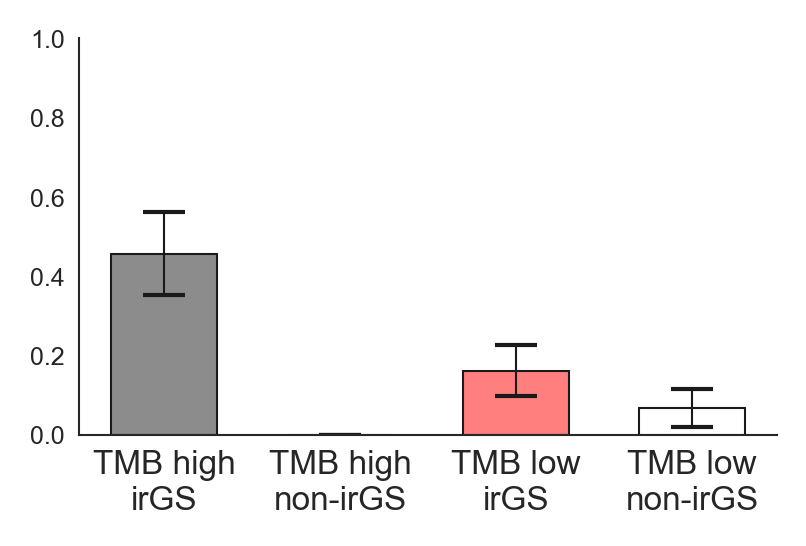

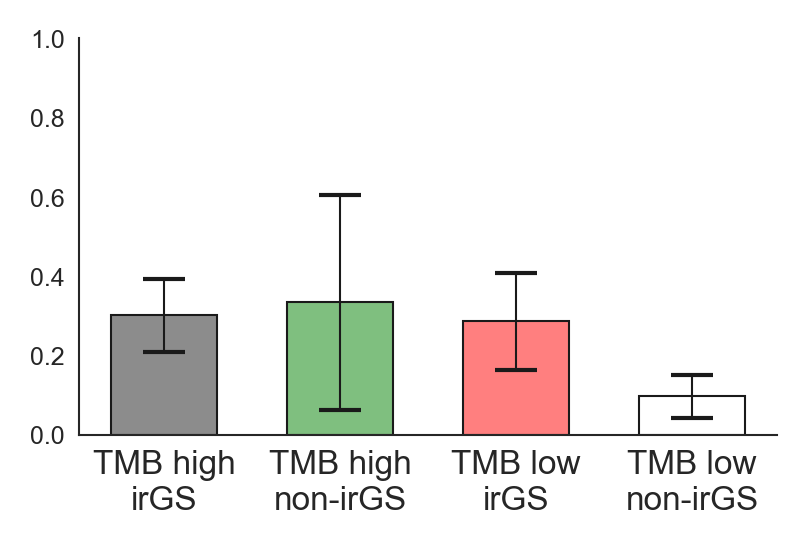

In [138]:
for i,plt_df in enumerate(dfs):
    ct4=pd.crosstab(plt_df["class4"],plt_df[flag]).T
    ratios=[]
    errors=[]
    labels=[]
    for col in ct4.columns:
        count=ct4.loc[1,col]
        nobs=np.sum( ct4.loc[:,col])
        ratio=count/nobs
        cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)

        ratios.append(ratio)   
        errors.append(np.array(cil-ratio, cih-ratio))
        labels.append(col)
        print(str(count)+"/"+str(nobs))
    else:
        print()
    
    n=len(ratios)
    left=range(n)
    colors=["k","green","red","white"]
    colors=[to_rgba(x, 0.5) for x in colors ]

    fig=plt.figure(figsize=(3,1.75))
    ax=fig.add_subplot(111)
    ax.bar(x=left,height=ratios,yerr=errors,
           tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
    ax.tick_params(labelsize=6)            
    ax.set_xticklabels(labels, rotation=0, fontsize=8)
    ax.legend([])
    ax.set_ylim(0,1)
    if i==0:
        ax.set_ylim(0,1.2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# KEYNOTEs only

In [140]:
df=df0[df0["Reference"]=='Cristescu, Science 2018']

In [142]:
input_df=df.copy()
flag="Responder"
cat1="irGS"
value="Missense_Mutation_log10"
ct=pd.crosstab(input_df[flag],input_df[cat1])
ct=ct.loc[:,[1,0]]
ct

irGS,1,0
Responder,,
0.0,102,135
1.0,56,18


In [143]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.11e-06
Chi-square p= 9.46e-07


In [144]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

56/158
18/153


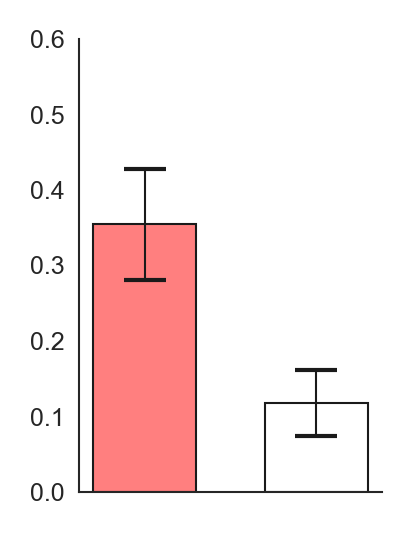

In [146]:
n=len(ratios)
left=range(n)
colors=["red","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.set_ylim(0,0.6)
ax.legend([])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [147]:
input_df=df.copy()
cat2="TMB_high"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high,1,0
Responder,,
0.0,49,188
1.0,40,34


In [148]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.15e-07
Chi-square p= 2.92e-08


In [149]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

40/89
34/222


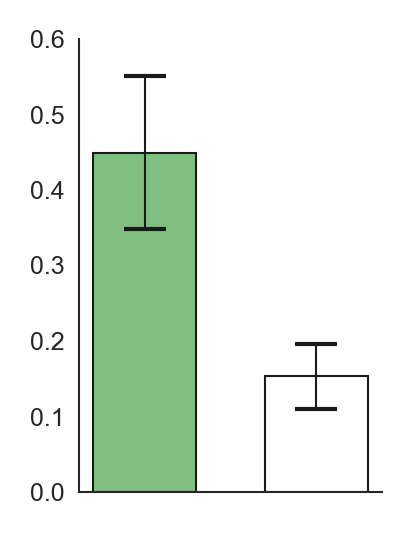

In [150]:
n=len(ratios)
left=range(n)
colors=["green","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

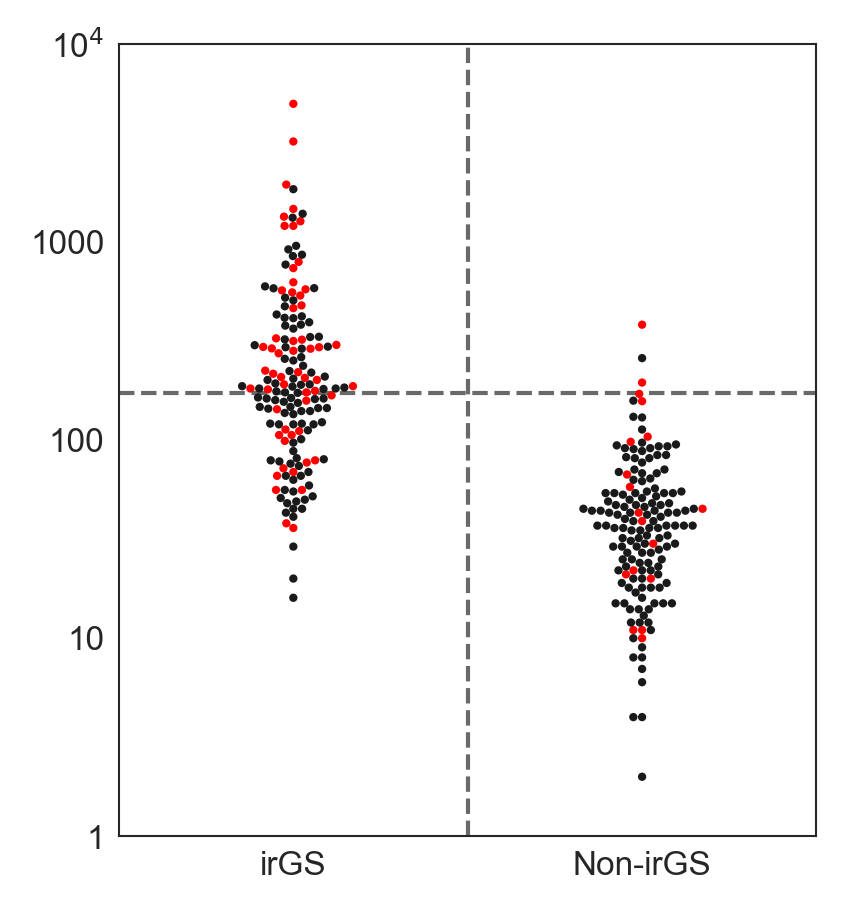

In [151]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels(["irGS","Non-irGS"], rotation=0, fontsize=8)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])

ax.axhline(y=np.log10(173),c="dimgrey",lw=1,ls="dashed")

#plt.savefig("Response_divided_GS_TMB_all.png",transparent=True)

In [152]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

<ipython-input-152-5c934862a787>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["class4"]=class4


In [153]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.loc[:, ['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS',
       'TMB low\nnon-irGS' ]]
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,48,1,54,134
1.0,38,2,18,16


In [154]:
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,54,134
1.0,18,16


Chi-square p= 5.50e-03


In [155]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

38/86
2/3
18/72
16/150


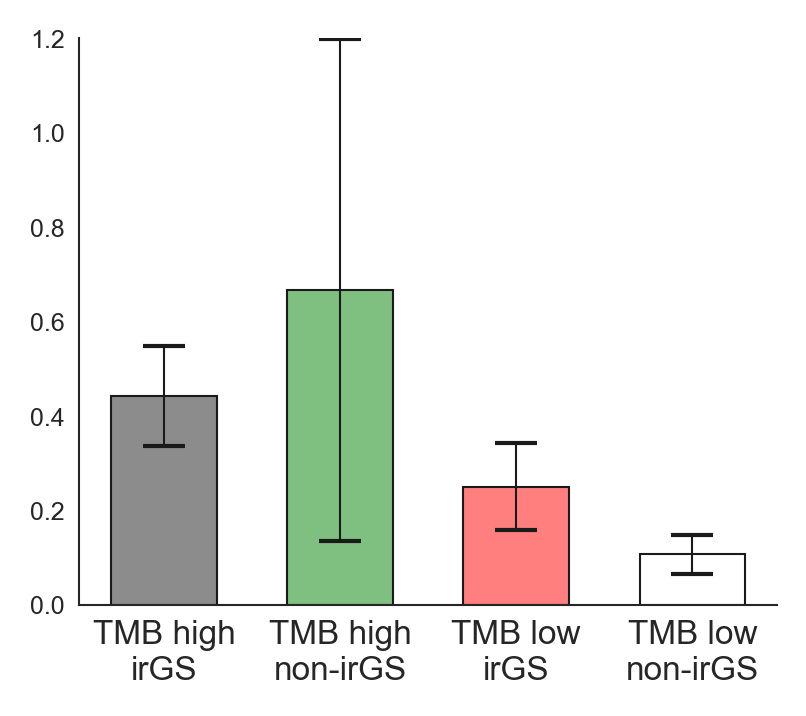

In [156]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","green","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,1.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression

In [157]:
Counter(df["irGS"])

Counter({1: 158, 0: 153})

In [158]:
Counter(df["TMB_high"])

Counter({1.0: 89, 0.0: 222})

In [159]:
Counter(df["CancerType"])

Counter({'Bladder': 17, 'Others': 95, 'Lung': 4, 'HNSCC': 106, 'Melanoma': 89})

In [160]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "3_Lung",
         'Bladder': "4_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "5_Others"})

<ipython-input-160-134a73364824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CancerTypeR"]=df["CancerType"].replace(


In [161]:
Counter(df["Sex"])

Counter({'Male': 194, 'Female': 117})

In [162]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

<ipython-input-162-1d1cbf9ddb6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sex_male"]=(df["Sex"]=="Male").astype(int)


In [163]:
m_age=np.nanmedian( df["Age"].astype(float))
print(m_age)
age_high=[]
for idx in df.index:
    if df.loc[idx,"Age"] >= m_age:
        age_high.append(1)
    elif df.loc[idx,"Age"] < m_age:
        age_high.append(0)
    else:
        age_high.append(np.nan)
    
df["Age_high"]=age_high
Counter(age_high)

61.0


<ipython-input-163-9e8fabcbd889>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age_high"]=age_high


Counter({1: 158, 0: 153})

In [164]:
Y="Responder"
categories=["irGS","TMB_high","CancerTypeR","Sex_male","Age_high"]

In [165]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,4.118,(2.28 - 7.43),0.000
TMB_high,4.514,(2.59 - 7.86),0.000
CancerTypeR[T.2_Head_neck],0.312,(0.16 - 0.59),0.000
CancerTypeR[T.3_Lung],0.000,(0.00 - inf),0.999
CancerTypeR[T.4_Bladder],0.288,(0.08 - 1.07),0.063
CancerTypeR[T.5_Others],0.213,(0.10 - 0.44),0.000
Sex_male,1.581,(0.90 - 2.77),0.110
Age_high,0.775,(0.46 - 1.31),0.339


2.58e-06
1.02e-07
3.85e-04
9.99e-01
6.34e-02
2.54e-05
1.10e-01
3.39e-01


In [167]:
# multivariate
categories=["irGS","TMB_high","CancerTypeR"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2g}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.224,(0.10 - 0.48),0.000
CancerTypeR[T.2_Head_neck],0.539,(0.26 - 1.10),0.090
CancerTypeR[T.3_Lung],0.000,(0.00 - inf),0.999
CancerTypeR[T.4_Bladder],0.323,(0.08 - 1.25),0.102
CancerTypeR[T.5_Others],0.546,(0.23 - 1.30),0.172
irGS,2.280,(1.06 - 4.89),0.034
TMB_high,2.189,(1.06 - 4.50),0.033


0.00014
0.09
1
0.1
0.17
0.034
0.033


# Using optimal TMB cutoff

In [182]:
df=df0.copy()

## TMB high vs low

In [183]:
input_df=df.copy()
cat2="TMB_high2"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high2,1,0
Responder,,
0.0,207,477
1.0,163,91


In [184]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 9.63e-21
Chi-square p= 3.63e-21


In [185]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

163/370
91/568


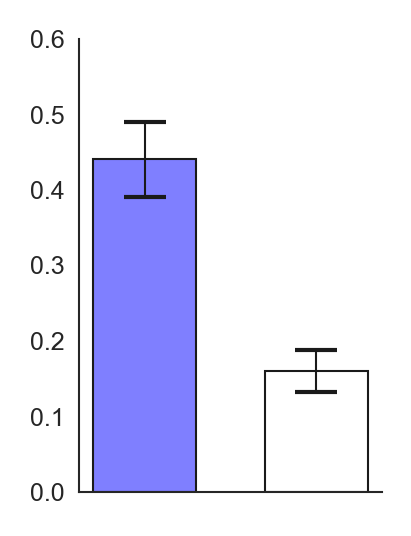

In [186]:
n=len(ratios)
left=range(n)
colors=["blue","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

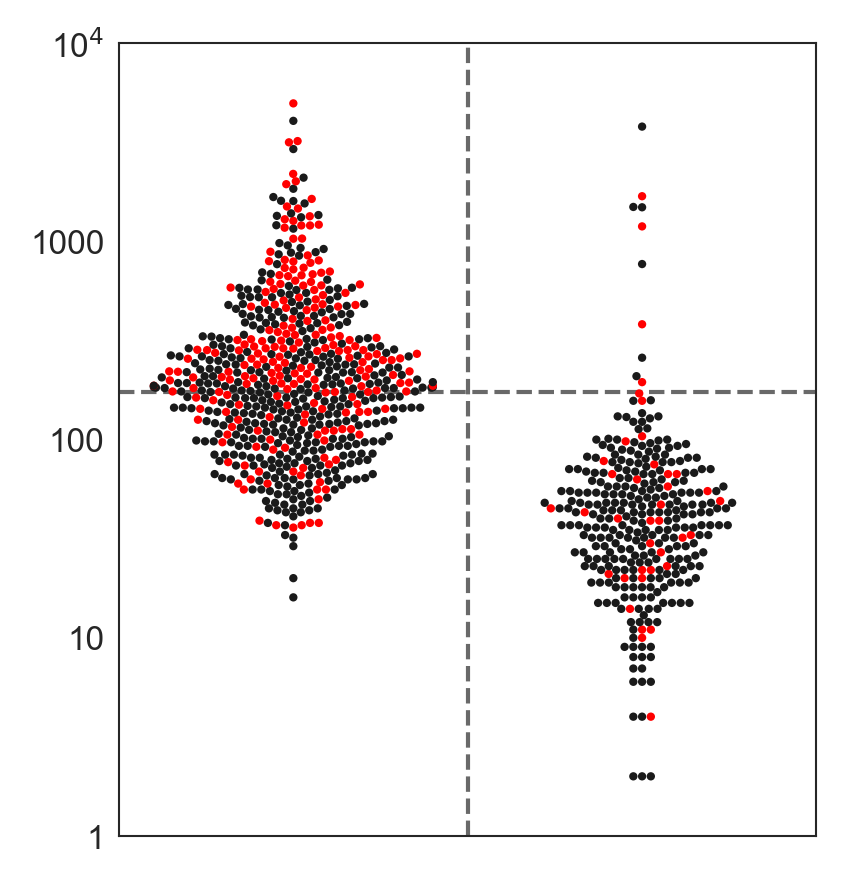

In [187]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axhline(y=np.log10(cutoff1),c="dimgrey",lw=1,ls="dashed")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels([])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])
#plt.savefig("Response_divided_GS_TMB_all.png",transparent=True)

In [188]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [189]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.reindex(['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS','TMB low\nnon-irGS'],axis=1)
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,201,6,203,274
1.0,158,5,58,33


In [190]:
# compare between TMB-low groups
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,203,274
1.0,58,33


Chi-square p= 2.03e-04


In [191]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,method="binom_test",alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

158/359
5/11
58/261
33/307


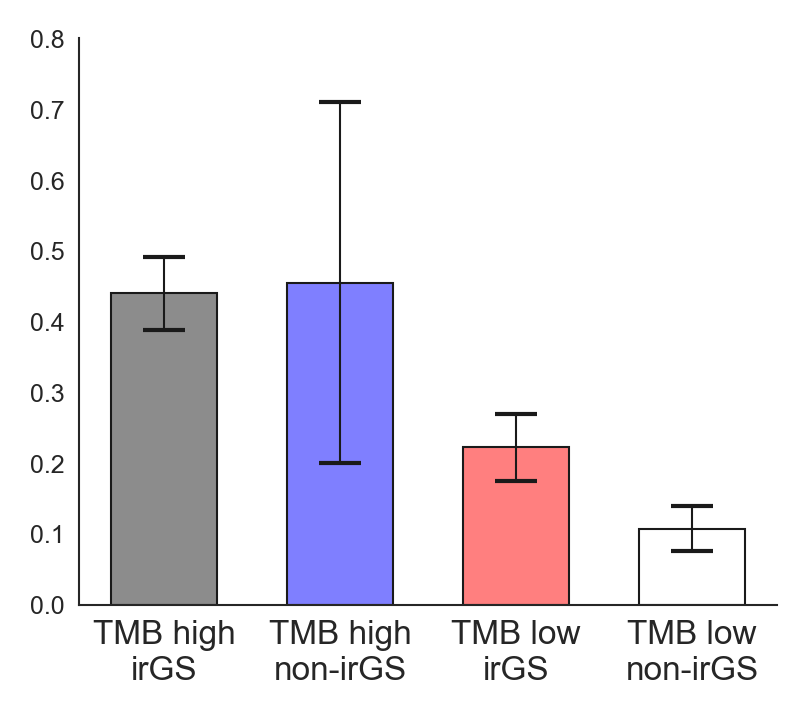

In [192]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","blue","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression 

In [193]:
Counter(df["irGS"])

Counter({1: 620, 0: 318})

In [194]:
Counter(df["TMB_high2"])

Counter({1.0: 370, 0.0: 568})

In [195]:
Counter(df["CancerType"])

Counter({'Melanoma': 335,
         'Lung': 127,
         'Bladder': 263,
         'HNSCC': 118,
         'Others': 95})

In [196]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "3_Lung",
         'Bladder': "4_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "5_Others"})

In [197]:
Counter(df["Sex"])

Counter({'Female': 326, 'Male': 612})

In [198]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

In [199]:
m_age=np.nanmedian( df["Age"].astype(float))
print(m_age)
age_high=[]
for idx in df.index:
    if df.loc[idx,"Age"] >= m_age:
        age_high.append(1)
    elif df.loc[idx,"Age"] < m_age:
        age_high.append(0)
    else:
        age_high.append(np.nan)
    
df["Age_high"]=age_high
Counter(age_high)

61.5


Counter({0: 319, 1: 319, nan: 300})

In [200]:
Y="Responder"
categories=["irGS","TMB_high2","CancerTypeR","Sex_male","Age_high"]

In [201]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,3.940,(2.70 - 5.74),0.000
TMB_high2,4.128,(3.05 - 5.59),0.000
CancerTypeR[T.2_Head_neck],0.482,(0.29 - 0.81),0.006
CancerTypeR[T.3_Lung],1.002,(0.65 - 1.55),0.993
CancerTypeR[T.4_Bladder],0.762,(0.53 - 1.09),0.136
CancerTypeR[T.5_Others],0.333,(0.18 - 0.62),0.001
Sex_male,1.192,(0.88 - 1.62),0.262
Age_high,1.067,(0.75 - 1.52),0.719


1.01e-12
6.17e-20
5.60e-03
9.93e-01
1.36e-01
6.08e-04
2.62e-01
7.19e-01


In [203]:
# multivariate
categories=["irGS","TMB_high2","CancerTypeR"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.133,(0.09 - 0.20),0.000
CancerTypeR[T.2_Head_neck],0.844,(0.48 - 1.47),0.548
CancerTypeR[T.3_Lung],1.352,(0.85 - 2.16),0.208
CancerTypeR[T.4_Bladder],0.902,(0.62 - 1.32),0.596
CancerTypeR[T.5_Others],0.903,(0.45 - 1.81),0.773
irGS,2.087,(1.32 - 3.30),0.002
TMB_high2,2.913,(2.03 - 4.18),0.000


9.36e-20
5.48e-01
2.08e-01
5.96e-01
7.73e-01
1.66e-03
7.13e-09


# Each dataset

In [204]:
df=df0.copy()

In [205]:
cat1="irGS"
cat2="TMB_high"

In [206]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [208]:
refs=list(df["Reference"].unique())
refs

['Snyder, NEJM 2014',
 'Van Allen, Science 2015',
 'Hugo, Cell 2016',
 'Riaz, Cell 2017',
 'Roh, SciTraMed 2017',
 'Liu, NatMed 2019',
 'Rizvi, Science 2015',
 'Hellmann, CanCel 2018',
 'Anagnostou, NatCan 2020',
 'Snyder, PlosMed 2017',
 'Mariathasan, Nature 2018',
 'Miao, NatGen 2018',
 'Cristescu, Science 2018']

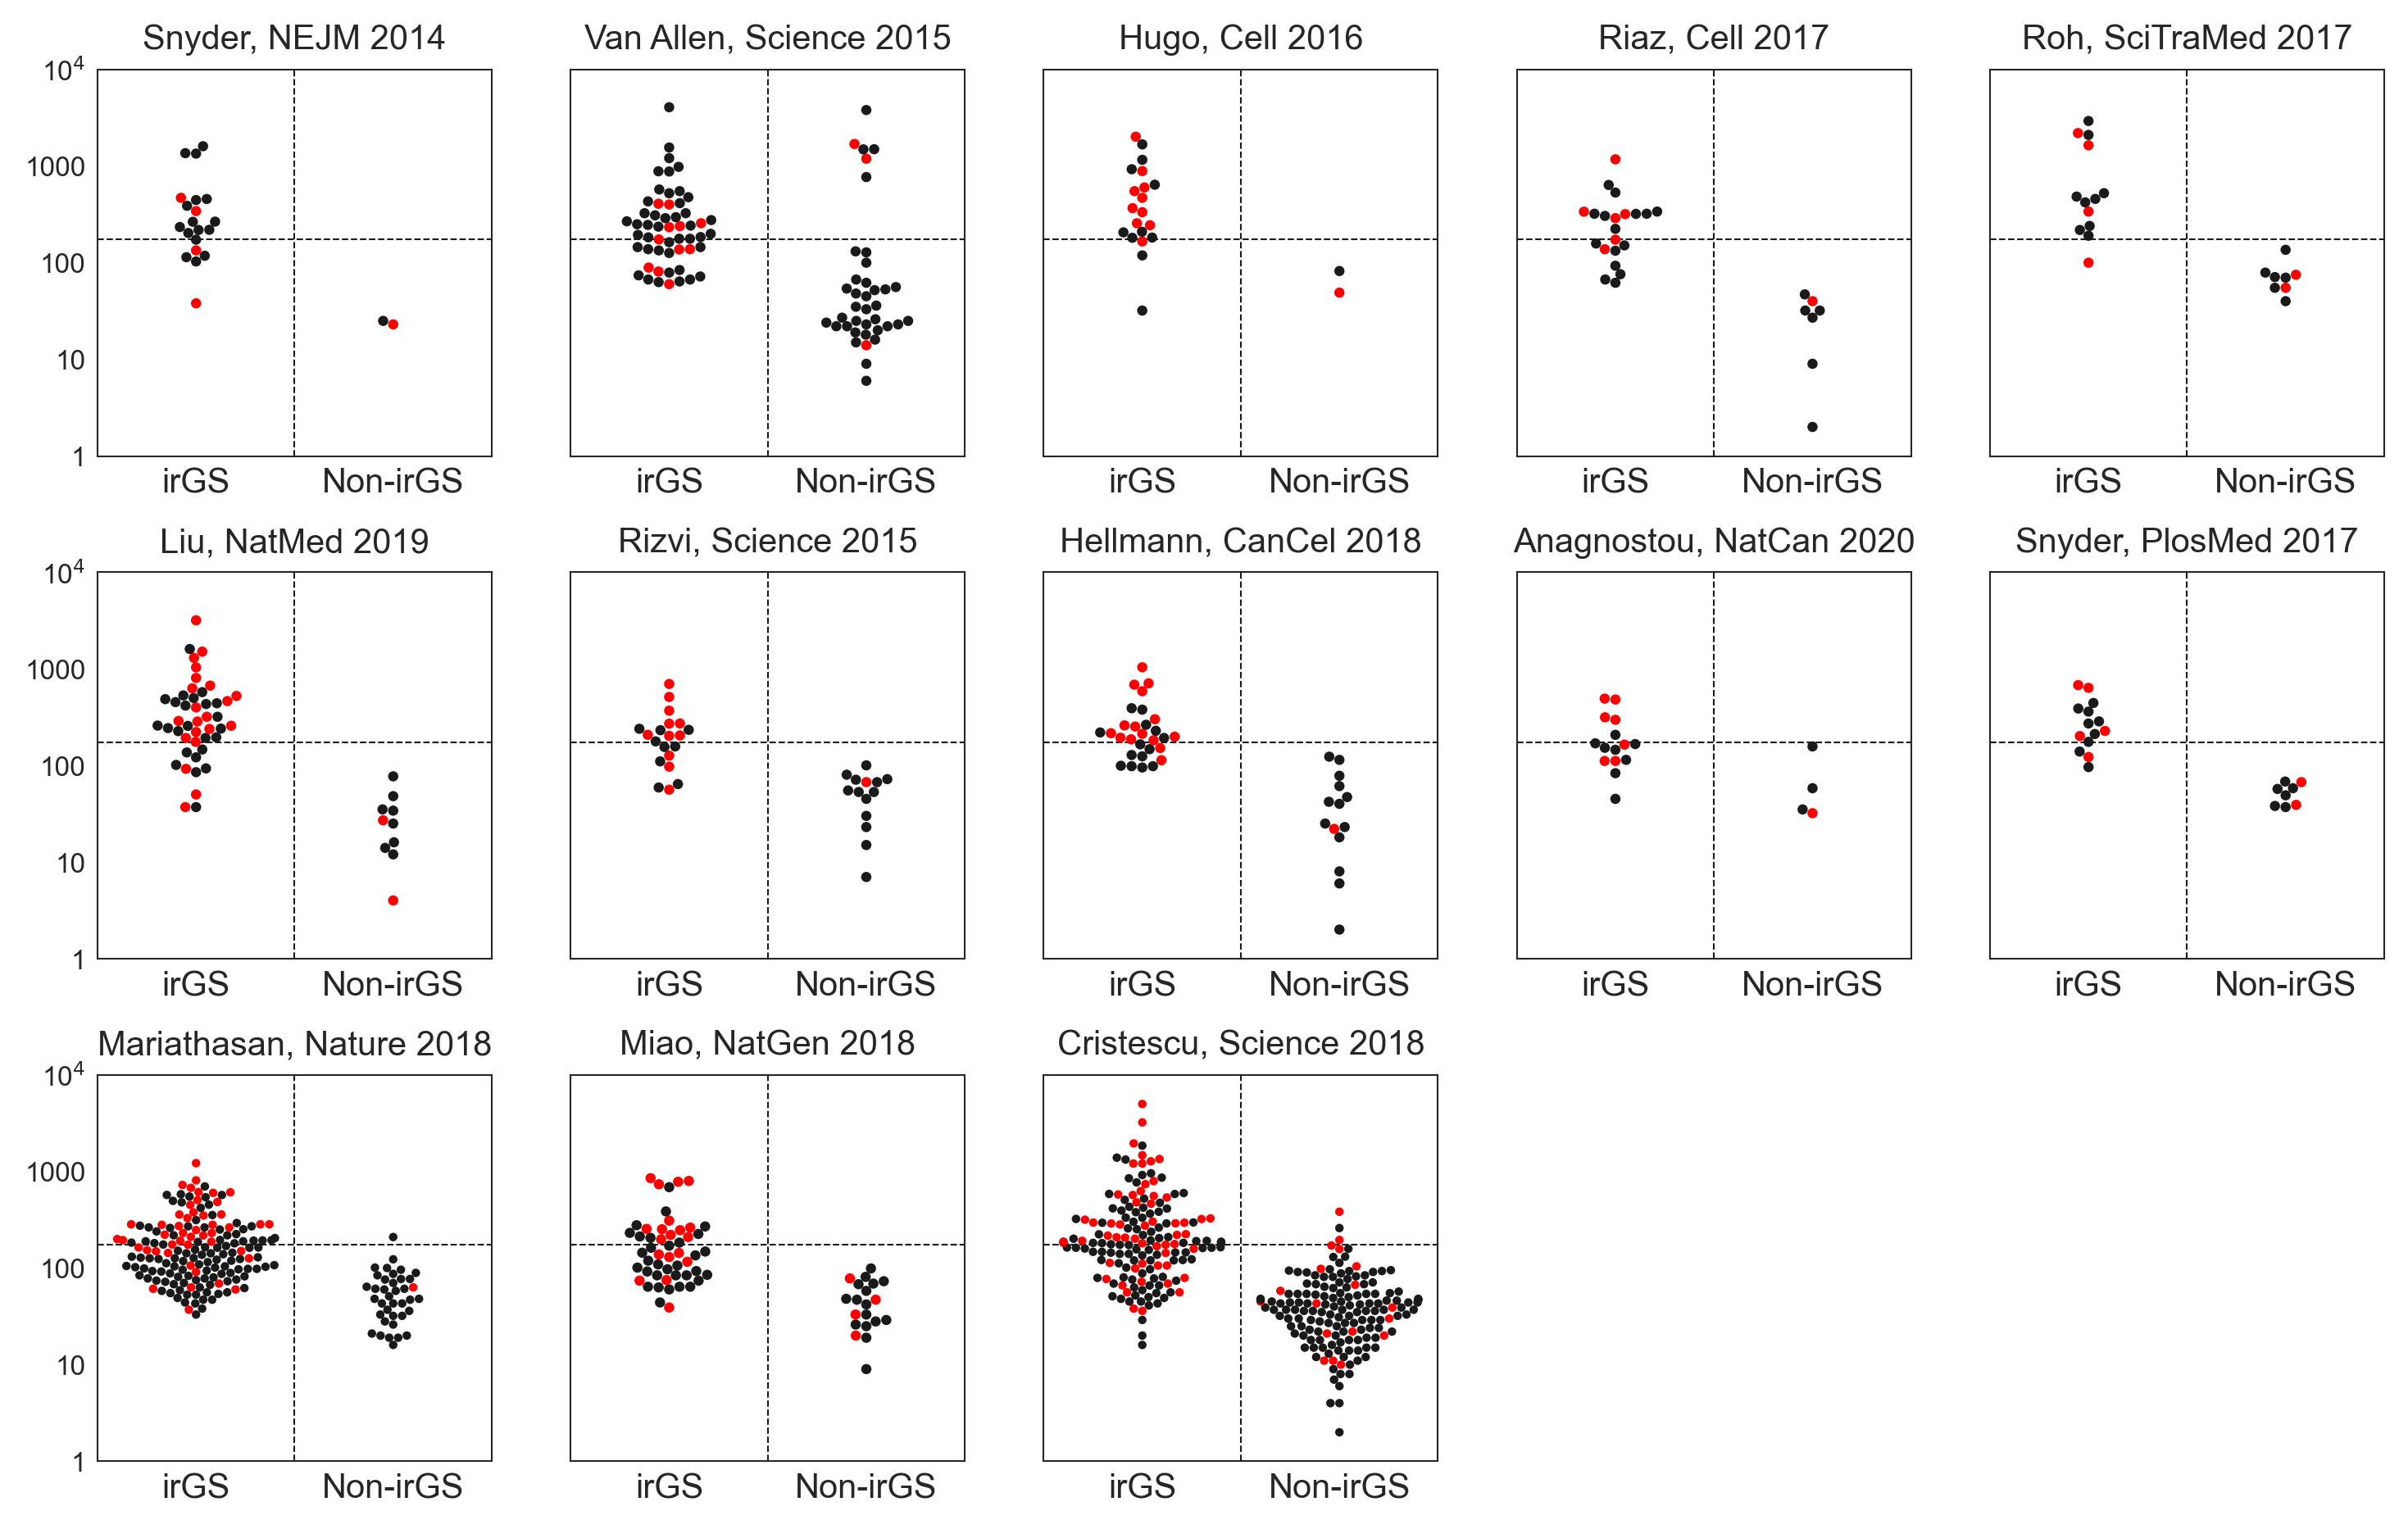

In [212]:
fig=plt.figure(figsize=(12,7.5))

for i,ref in enumerate(refs):
    if ref =="":
        continue
    input_df=df[df["Reference"]==ref]
    ax=fig.add_subplot(3,5,i+1)
    sns_df=input_df.copy()
    ax.axhline(y=np.log10(174),color="k",ls="dashed")
    ax.axvline(x=0.5,color="k",ls="dashed")
    ax.set_ylim(0,4)
    ax.tick_params(labelsize=6)
    s=3
    if len(input_df)>=100:
        s=2.5
    ax=sns.swarmplot(x="irGS",y="Missense_Mutation_log10",order=[1,0],data=sns_df,
                     hue="Responder",palette=["k","red"],s=s)
    ax.legend([])
    ax.set_title(ref,fontsize=10)
    ax.set_xlabel("")#'TMB log10',fontsize=8)
    ax.set_ylabel("")
    ax.set_xticklabels(["irGS","Non-irGS"],fontsize=10)
    
    if i in [0,5,10]:
        ax.set_yticks([0,1,2,3,4])
        ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8) 
    else:
        ax.set_yticklabels([])

plt.subplots_adjust(hspace=0.3,wspace=0.2)
#plt.savefig(path_to_res+"SciTra2017_MEL_OR_2dplot.png",dpi=300,bbox_inches="tight")

In [214]:
ct=pd.crosstab(df["Reference"],df["Tumor genomic subtype"])
ct.loc[refs,cluster_order2]

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
Reference,,,,,,,,,
"Snyder, NEJM 2014",0,20,0,0,0,1,0,1,0
"Van Allen, Science 2015",0,54,0,0,0,9,7,10,12
"Hugo, Cell 2016",0,20,0,0,0,1,0,0,1
"Riaz, Cell 2017",1,20,0,0,0,3,1,3,0
"Roh, SciTraMed 2017",1,11,0,0,0,4,0,4,1
"Liu, NatMed 2019",0,45,0,0,0,4,4,2,0
"Rizvi, Science 2015",17,0,2,0,0,6,1,5,3
"Hellmann, CanCel 2018",27,0,2,0,0,2,4,8,0
"Anagnostou, NatCan 2020",13,0,2,0,0,1,0,3,0
